# BEAT-PD Challenge

Challenge website : https://www.synapse.org/#!Synapse:syn20825169/wiki/596118

Data information : https://www.synapse.org/#!Synapse:syn20825169/wiki/600405


### Ideas/Doubts [Laureano]

VAD like thing to remove unwanted data?
modified MFCC?
X,Y,Z = relative positions or acceleration?

Imp: Predict per person. Maybe UBM like thing and adapt it

In [57]:
# Import required libraries

import pandas as pd
from IPython.display import display, HTML

%matplotlib inline
import matplotlib.pyplot as plt

# Import required modules
from sklearn.preprocessing import StandardScaler

In [58]:
# Data paths

data_dir='/home/sjoshi/codes/python/BeatPD/data/BeatPD/'
path_save_accelerometer_plots='/home/sjoshi/codes/python/BeatPD/code/accelerometer_plots/'
path_save_k_fold_dataframes='/home/sjoshi/codes/python/BeatPD/df_k_fold/'

path_save_silence_removed=data_dir

In [59]:
def define_data_type(data_type):
    # Setup file names

    '''
    data_type={cis , real}

    If data_type is real, data_real_subtype 
    data_real_subtype={smartphone_accelerometer , smartwatch_accelerometer , smartwatch_gyroscope}
    '''
    if data_type=='cis':
        path_train_labels=data_dir+data_type+'-pd.data_labels/'+data_type.upper()+'-PD_Training_Data_IDs_Labels.csv'
        path_train_data=data_dir+data_type+'-pd.training_data/'

    if data_type=='real':
        path_train_labels=data_dir+data_type+'-pd.data_labels/'+data_type.upper()+'-PD_Training_Data_IDs_Labels.csv'
        path_train_data=data_dir+data_type+'-pd.training_data/'+data_real_subtype+'/'

    # Display labels
    df_train_label=pd.read_csv(path_train_labels)
    return path_train_data, df_train_label

In [79]:
def plot_accelerometer(data_type, path_accelerometer_plots, path_silence=None):
    # Iterating through all the indexes contained in df_train_label
    for idx in df_train_label.index:
        if path_silence is None:
            df_train_data=pd.read_csv(path_train_data+df_train_label["measurement_id"][idx]+'.csv')
        else:
            df_train_data=pd.read_csv(path_silence+df_train_label["measurement_id"][idx]+'.csv')
        # FIXME: BUG ?  why the following goes to 1000xxx sometimes? It should be max 59xxx
        #display(df_train_data)
        print('measurement_id : ', df_train_label["measurement_id"][idx])
        # Following val_* variables are only used to format a cute title for the charts
        val_subject_id = df_train_label.loc[[idx]]['subject_id'].values[0]
        val_on_off = df_train_label.loc[[idx]]['on_off'].values[0]
        val_dyskinesia = df_train_label.loc[[idx]]['dyskinesia'].values[0]
        val_tremor = df_train_label.loc[[idx]]['tremor'].values[0]
        great_title = "{0} = on_off: {1}, dyskinesia: {2}, tremor: {3}".format(val_subject_id, val_on_off, val_dyskinesia, val_tremor)

        # The time doesn't have the same name depending on the data_type
        x_axis_data_type = 't' if data_type == 'real' else 'Timestamp'
        
        # Normalize the data
        cols_to_norm = ['x','y','z'] if data_type == 'real' else ['X','Y','Z']
        df_train_data[cols_to_norm] = df_train_data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
        
        df_train_data.plot(x=x_axis_data_type,legend=True, subplots=True,title=great_title)

        # Save plotted graph with the measurement_id as name of the file
        plt.savefig(path_accelerometer_plots+df_train_label["measurement_id"][idx]+'.png')
        plt.show()
        plt.clf()
        plt.cla()
        plt.close()

In [61]:
def prepro_missing_values(df_train_label):
    # Replace NaN values with -1.0 because otherwise plotting triggers an error 
    df_train_label = df_train_label.fillna(value=-1.0)
    return df_train_label

def compute_symptoms_occurences_dataframe(df_train_label):
    df_train_label = prepro_missing_values(df_train_label=df_train_label)
    
    # Group data by subject_id 
    df_train_label_subject_id = df_train_label.groupby('subject_id')

    df_occurences = []
    symptoms = ['on_off', 'dyskinesia', 'tremor']
    
    for key, value in df_train_label_subject_id :
        for symptom in symptoms:
            # Pour un patient, prendre les 3 dernieres colonnes, et pour 1 symptome, calculer le nb d'occurences
            counter = df_train_label_subject_id.get_group(key).iloc[:,-3:][symptom].value_counts()

            for symptom_value, symptom_occurence in counter.items():
                df_occurences.append(({'subject_id': key, 'symptom': symptom, 'symptom_value': symptom_value, 'occurence': symptom_occurence}))

    df_occurences = pd.DataFrame(df_occurences, columns=('subject_id', 'symptom', 'symptom_value', 'occurence'))
    
    return df_occurences, df_train_label_subject_id


In [62]:
'''
This function plots the occurences of symptoms according to subject_id 

Arguments: 
- df_occurences: contains the df with occurences computed in compute_symptoms_occurences_dataframe
- df_train_label_subject_id: contains df_train_label grouped by subject_id 
'''
def plot_symptoms_occurences(df_occurences, df_train_label_subject_id):
    
    # There will be one graph plotted for each patient, for each of the 3 symptoms
    nb_subjects_id = df_occurences.subject_id.nunique() # nb of unique patients in the label file
    print("Nb subject_id : ", nb_subjects_id)
    height = 30 if nb_subjects_id > 10 else 10
    fig, axes = plt.subplots(nrows=nb_subjects_id, ncols=3, figsize=(10,height), sharey=True) # 3 cols for the 3 symptoms
    
    # Quick fix to plot the graphs at the right place. Starts at -1 because in the first for loop 
    # it is incremented
    patient = -1

    # Plot for all subject_id 3 bar plots for all the symptoms and their occurences
    # Reminder that NaN values (missing values) were replaced with -1 and are shown as such in the plots
    symptoms = ['on_off', 'dyskinesia', 'tremor']
    for key, value in df_train_label_subject_id :
        patient = patient + 1 # value used to position the plots (row)
        symptom_no = 0 # value only used to position the plots (col)
        for symptom in symptoms:
            subject_symptom = ' '.join([str(key), symptom]) # variable used to create a title for each plot
            df_train_label_subject_id.get_group(key)[symptom].value_counts().plot(kind='bar',
                                                                                  x=symptom,
                                                                                  title=subject_symptom, 
                                                                                  ax=axes[patient,symptom_no],
                                                                                  sharey=True)
                                                                                  
            fig.tight_layout()
            plt.tight_layout()
            symptom_no = symptom_no + 1

In [63]:
'''
Filters df_train_label according to a list of measurement_id we are interested in analyzing

Arguments:
- df_train_label: dataframe with labels
- list_measure_id: list of measurement_id 

Returns:
- df_train_label: filtered df_train_label containing only the measurements_id we are interested in 
'''
def interesting_patients(df_train_label, list_measurement_id):
    filter_measurement_id = df_train_label.measurement_id.isin(list_measurement_id)

    df_train_label = df_train_label[filter_measurement_id]
    display(df_train_label)
    return df_train_label

possible to have participant characteristics from additional db data? ex https://ieeexplore.ieee.org/abstract/document/7911257

# CIS-PD Database

Contains 16 subject_id (patients) for the training set 

- Gender: 11 Male, 5 Female 
- Race: 15 White, 1 NA
- Ethnicity: 15 Not Hispanic or Latino, 1 Unknown
- Age average (standard deviation) : 62.8125 (10.8579)

,measurement_id,subject_id,on_off,dyskinesia,tremor
668,db2e053a-0fb8-4206-891a-6f079fb14e3a,1023,4.0,1.0,0.0


measurement_id :  db2e053a-0fb8-4206-891a-6f079fb14e3a


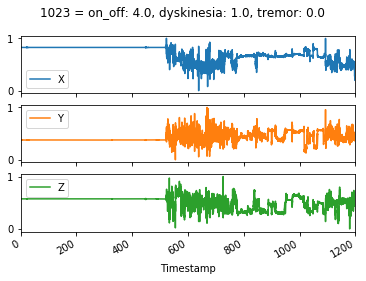

AAAAAAAAAAA 1
AAAAAAAAAAA 2
idx :  668
AAAAAAAAAAA
AAAAAAAAAAA
path no silence :  /home/sjoshi/codes/python/BeatPD/data/BeatPD/cis-pd.training_data.no_silence//
measurement_id :  db2e053a-0fb8-4206-891a-6f079fb14e3a


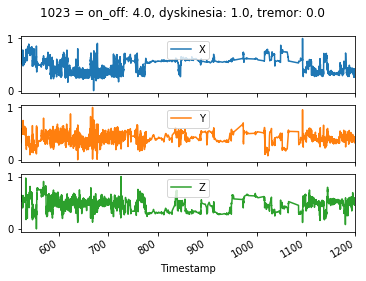

In [132]:
data_type='cis'

# TODO: explain
path_train_data, df_train_label = define_data_type(data_type=data_type)

# List of interesting measurement id we want to look at 
list_measurement_id=[#'ab5287f4-8261-47ad-8ff2-22b5fe5d246e',
'db2e053a-0fb8-4206-891a-6f079fb14e3a']#,
# 'ef5b1267-c212-46c5-aab0-4f4437bc6c67',
# '4ec74fb9-7347-435d-83dc-79ad74c3bc49',
# '8e8539ad-8841-476b-b15c-888ce3461989',
# '22b88456-fe8f-4138-af55-be12afca4b81',
# 'ad84583d-e5ae-4926-b077-531a0f7d08a9',
# 'eef56825-940a-4c3e-aebb-60838d60869e',
# 'e0441156-c4b8-467c-8f4f-3b532d594d8f',
# '464ac314-6c4b-4c4a-957c-28a2339150d6']

# Filter df_train_label according to the measurement_id we are most interested in
df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)

# Display filtered df_train_label
#display(df_train_label)

# Plot the accelerometer data 
plot_accelerometer(data_type=data_type, path_accelerometer_plots=path_save_accelerometer_plots)

path_no_silence_data = remove_silence(df_train_label)

# Plot the accelerometer data 
plot_accelerometer(data_type=data_type, path_accelerometer_plots=path_save_accelerometer_plots, path_silence=path_no_silence_data)


## WIP : Function to remove silence (inactivity)

In [162]:
'''
Save .csv files with silence (inactivity) removed 

Path used: 
# cis-pd.training_data.no_silence/
# real-pd.training_data.no_silence/smartphone_accelerometer/
# real-pd.training_data.no_silence/smartwatch_accelerometer/
# real-pd.training_data.no_silence/smartwatch_gyroscope/
# data_type = {'cis', 'real'}
        
Arguments:
df_train_label: Dataframe with training labels

data_real_subtype: Optional. If data_type is real, data_real_subtype needs to be provided
    data_real_subtype={smartphone_accelerometer , smartwatch_accelerometer , smartwatch_gyroscope}
    
Returns: 
path_no_silence_data: Return the path where the files are saved because it is needed
                      if we want to plot the accelerometer, for example
'''
#FIXME: BUG: PCT change on all axis separately? 
def remove_silence(df_train_label, data_real_subtype=''):
    for idx in df_train_label.index: 
        df_train_data=pd.read_csv(path_train_data+df_train_label["measurement_id"][idx]+'.csv')
        print('measurement id : ', df_train_label["measurement_id"][idx])
        display(df_train_data)
        cols_to_norm = ['x','y','z'] if data_type == 'real' else ['X','Y','Z']
        df_train_data[cols_to_norm] = df_train_data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
        df_pct_change = df_train_data.iloc[:,-3:].pct_change(periods=5)
        #df_pct_change = df_train_data['X'].pct_change(periods=5)
        df_pct_change.columns = ['X', 'Y','Z']
        print('pct_change measurement id : ', df_train_label["measurement_id"][idx])
        display(df_pct_change)
        df_pct_change = df_pct_change[df_pct_change > 0.01]

        filter_df = df_train_data[df_train_data.index.isin(df_pct_change.index.to_list())]
        
        # To provide the name of the header for the Dataframe, we get the name of the x axis as it depends
        # on the data_type and then we insert it at the first position before the X,Y,Z axis 
        x_axis_data_type = 't' if data_type == 'real' else 'Timestamp'
        cols_to_norm.insert(0, x_axis_data_type)

        # Save the dataframe in a file with the measurement_id as the name of the file
        path_no_silence_data = data_dir+data_type+'-pd.training_data.no_silence/'+data_real_subtype+'/'
        filter_df.to_csv(path_no_silence_data+df_train_label["measurement_id"][idx]+'.csv', index=False, header=cols_to_norm)
    return path_no_silence_data



,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1.0,1.0,1.0
1,5163afe8-a6b0-4ea4-b2ba-9b4501dd5912,1004,0.0,0.0,0.0
2,5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a,1004,1.0,1.0,1.0


measurement id :  cc7b822c-e310-46f0-a8ea-98c95fdb67a1


,Timestamp,X,Y,Z
0,0.000,-1.090332,-0.237793,0.395508
1,0.020,-1.267822,-0.102051,0.172852
2,0.040,-1.185791,-0.089600,0.017090
3,0.060,-1.176270,-0.077637,-0.002197
4,0.080,-1.211670,-0.013672,-0.079590
5,0.100,-1.226562,0.003906,-0.023682
6,0.120,-1.420410,0.342529,0.171387
7,0.140,-1.413574,0.643555,0.401611
8,0.160,-1.238037,0.494385,0.283203
9,0.180,-1.049560,0.406982,0.256836


pct_change measurement id :  cc7b822c-e310-46f0-a8ea-98c95fdb67a1


,X,Y,Z
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,-0.031877,0.097556,-0.117434
6,-0.037251,0.170123,-0.000438
7,-0.054517,0.279219,0.120496
8,-0.014750,0.216864,0.089978
9,0.039040,0.155702,0.108718


measurement id :  5163afe8-a6b0-4ea4-b2ba-9b4501dd5912


,Timestamp,X,Y,Z
0,0.000,0.018066,-0.024414,-0.985352
1,0.020,0.019043,-0.024414,-0.983887
2,0.040,0.018555,-0.023926,-0.984863
3,0.060,0.018555,-0.023438,-0.985840
4,0.080,0.017578,-0.023438,-0.984375
5,0.100,0.019043,-0.023926,-0.986816
6,0.120,0.018066,-0.023926,-0.985352
7,0.140,0.018555,-0.024414,-0.985352
8,0.160,0.018555,-0.024902,-0.985840
9,0.180,0.019043,-0.024414,-0.985840


pct_change measurement id :  5163afe8-a6b0-4ea4-b2ba-9b4501dd5912


,X,Y,Z
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,0.000139,0.000245,-0.000620
6,-0.000139,0.000245,-0.000620
7,0.000000,-0.000245,-0.000207
8,0.000000,-0.000736,0.000000
9,0.000209,-0.000491,-0.000620


measurement id :  5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a


,Timestamp,X,Y,Z
0,0.000,-0.466553,0.812500,-0.336670
1,0.020,-0.463135,0.818115,-0.336670
2,0.040,-0.462646,0.822021,-0.338623
3,0.060,-0.461182,0.820557,-0.338135
4,0.080,-0.457520,0.820068,-0.336914
5,0.100,-0.459717,0.817139,-0.334473
6,0.120,-0.466064,0.812988,-0.334229
7,0.140,-0.466064,0.811523,-0.336182
8,0.160,-0.466064,0.815674,-0.339111
9,0.180,-0.470459,0.813477,-0.333252


pct_change measurement id :  5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a


,X,Y,Z
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,0.001448,0.001633,0.000918
6,-0.000620,-0.001802,0.001019
7,-0.000723,-0.003684,0.001020
8,-0.001033,-0.001715,-0.000408
9,-0.002735,-0.002315,0.001529


measurement_id :  cc7b822c-e310-46f0-a8ea-98c95fdb67a1


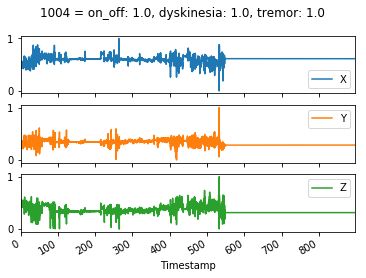

measurement_id :  5163afe8-a6b0-4ea4-b2ba-9b4501dd5912


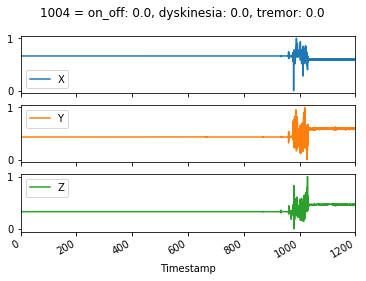

measurement_id :  5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a


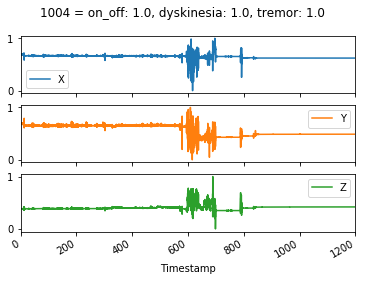

In [163]:
data_type='cis'

# TODO: explain
path_train_data, df_train_label = define_data_type(data_type=data_type)

list_measurement_id=['5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a',
                     'cc7b822c-e310-46f0-a8ea-98c95fdb67a1',
                     '5163afe8-a6b0-4ea4-b2ba-9b4501dd5912']

df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)

path_no_silence_data = remove_silence(df_train_label)

# Plot the accelerometer data 
plot_accelerometer(data_type=data_type, path_accelerometer_plots=path_save_accelerometer_plots, path_silence=path_no_silence_data)



## Visualization: Occurences of each symptoms for each subject

Nb subject_id :  2


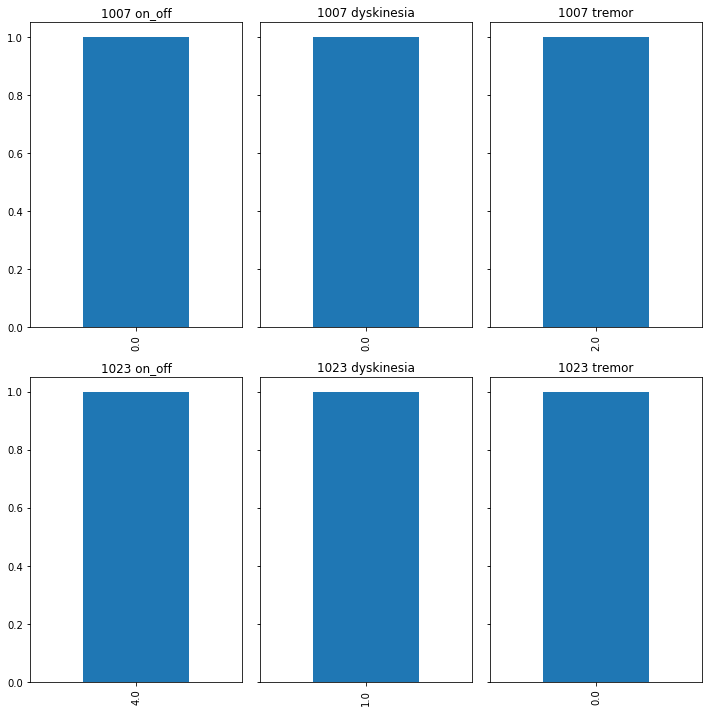

In [66]:
# Compute the occurences of each symptoms for each patient
df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(df_train_label=df_train_label)

# Plot the graphs 
plot_symptoms_occurences(df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id)

## KFold 

In [67]:
# KFold 
import numpy as np
from sklearn.model_selection import KFold

'''
Function that returns a list of X dataframes (X is according to the number of n_splits chosen)

The dataframes are the labels needed according to the split 

Arguments:
df_train_label: Dataframe containing the labels
n_split: Optional. The number of folds. Default: 5
subject_id: Optional. Specify a subject_id to get measurement_id only for that subject_id 
data_real_subtype: Only for REAL-PD database
'''
def get_k_fold(df_train_label, n_splits=5, subject_id=None, data_real_subtype=''):
    kf = KFold(n_splits)
    
    # Building the dataframe to split
    X = []

    #if we want the data split for one specific subject_id
    if subject_id: 
        df_train_label_subject_id = df_train_label.groupby('subject_id')
        X = df_train_label_subject_id.get_group(subject_id)
        
    # if we want to have all a split for all data no matter the subject_id
    # NOTE: I didn't make sure to have one subject_id represented in both train/test
    else: 
        for idx in df_train_label.index: 
            X.append([df_train_label["measurement_id"][idx]])
        X = pd.DataFrame(X)

    kf.get_n_splits(X)

    # Building lists of df_train_label because we have by default 5 splits, 
    # so the lists will contain 5 DataFrames with different split indices required
    list_df_train_label = list()
    list_df_test_label = list()
    split_idx=0
    for train_index, test_index in kf.split(X):
        df_train_label = X.iloc[train_index]
        df_test_label = X.iloc[test_index]

        list_df_train_label.append(df_train_label)
        list_df_test_label.append(df_test_label)
        
        #name of the file according to its database and type 
        # Example: cis_
        df_train_label.to_csv(path_save_k_fold_dataframes+data_type+data_real_subtype+'_train_'+str(subject_id)+'_kfold_'+str(split_idx), index=False, header=False)
        df_test_label.to_csv(path_save_k_fold_dataframes+data_type+data_real_subtype+'_test_'+str(subject_id)+'_kfold_'+str(split_idx), index=False, header=False)
        split_idx = split_idx + 1 
    return list_df_train_label, list_df_test_label 

In [68]:
# Define the data type as we have two databases 
data_type='cis'
path_train_data, df_train_label = define_data_type(data_type=data_type)
display(df_train_label)

# Group data by subject_id 
df_train_label_subject_id = df_train_label.groupby('subject_id')

# Go through the subject_id and k-fold their data
for subject_id, value in df_train_label_subject_id :
    list_df_train_label, list_df_test_label = get_k_fold(df_train_label=df_train_label, 
                                                         n_splits=5, 
                                                         subject_id=subject_id)


#### Example on how to read data (commented as not needed right now): 

# Iterate through the DataFrame in the list list_df_train_label_train
# for df_train_label in list_df_train_label_train:
#     # Go through the measurement_id for this df_train_label split to read the training data corresponding
#     for idx in df_train_label.index: 
#         # Read the train data for this specific measurement_id 
#         # TODO: Do we want to append all of this training data together?
#         df_train_data=pd.read_csv(path_train_data+df_train_label["measurement_id"][idx]+'.csv')
#     #display(df_train_label)


,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1.0,1.0,1.0
1,5163afe8-a6b0-4ea4-b2ba-9b4501dd5912,1004,0.0,0.0,0.0
2,5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a,1004,1.0,1.0,1.0
3,fb188ae2-2173-4137-9236-19a137a402c2,1004,3.0,3.0,3.0
4,19a3e9ea-fce1-40b7-9457-2618970beb7b,1004,1.0,1.0,1.0
5,e2973da8-1250-4a7c-98d5-b165570a8aeb,1004,1.0,1.0,1.0
6,8548d34c-4771-4ca4-bee4-d47bde435bdc,1004,2.0,2.0,2.0
7,0c579a72-bac5-46a2-8671-1a50620723bf,1004,2.0,2.0,2.0
8,bb59d008-25fe-43cc-bf05-6bd6b874eea3,1004,3.0,3.0,3.0
9,4a1ca52c-2895-4094-bade-246fd474762f,1004,3.0,3.0,3.0


In [69]:
data_type='real' 
#data_real_subtype='smartphone_accelerometer' 
#data_real_subtype='smartwatch_accelerometer'
data_real_subtype='smartwatch_gyroscope'

path_train_data, df_train_label = define_data_type(data_type=data_type)

display(df_train_label)

# Group data by subject_id 
df_train_label_subject_id = df_train_label.groupby('subject_id')

# Go through the subject_id and k-fold their data
for subject_id, value in df_train_label_subject_id :
    list_df_train_label, list_df_test_label = get_k_fold(df_train_label=df_train_label, 
                                                         n_splits=5, 
                                                         subject_id=subject_id, 
                                                         data_real_subtype='_'+data_real_subtype)




,measurement_id,subject_id,on_off,dyskinesia,tremor
0,ee053d95-c155-400d-ae42-fe24834ad4a9,hbv013,1.0,0.0,3.0
1,ce51ee31-8553-4321-9f83-8cd3dabe2f66,hbv013,1.0,0.0,2.0
2,d3c89012-3ab9-4014-b577-61ff05e31968,hbv013,1.0,0.0,0.0
3,5c42911d-0ebd-47ba-9925-dd5ab1c0ed61,hbv013,1.0,0.0,1.0
4,235472d5-ad2e-4c76-947e-358c9d8c1280,hbv013,1.0,0.0,0.0
5,274f5bc8-2e4f-4d7c-a546-b65b7d6bd01e,hbv013,0.0,0.0,NaN
6,39cf118c-e2bb-4e3f-adb1-d200ee20e1fa,hbv013,0.0,1.0,0.0
7,ecbeea40-8770-455d-90a6-597e7f896e1b,hbv013,0.0,1.0,0.0
8,d3171986-f881-4fa8-9c61-a72a3ad3ae26,hbv013,1.0,0.0,0.0
9,96090095-7b0f-423f-ac9a-d69b7d1b638c,hbv013,0.0,1.0,0.0


# REAL-PD Database

This database, originally named "Parkinson@Home" is renamed to "Real-PD" for this challenge. The study was made over 2 weeks, with at home monitoring. 

The devices used are an android phone, a motorolla watch. 
- `smartwatch_accelerometer` and `smartwatch_gyroscope` : Motorolla Watch
- `smartphone_accelerometer` : Android phone 

-> Question: so is the smartwatch & smartphone accelerometer should measure the same movements? 

The REAL-PD database has many missing values. 

The subject_id `hbv013` is the only one without missing data. Other patients all have at least one missing symptom (`diskenisia`, ) or two (`on/off and tremor`, `on_off and dyskinesia`, `dyskinesia and tremor`) missing.

Measurements id with no data (`on_off`, `dyskinesia` and `tremor` are all missing):
- `b50d1b0c-2cd1-45f8-9097-0742e5cbbcc8`
- `b598c177-4e38-4ea8-8543-bd8f7e580f96`
- `cf841bf8-0082-4ea3-999f-1f43e39a8dc6`
- `b1e15f8a-109f-459b-ba87-46899240ee66`
- `6f0e2580-56ec-4743-9356-d3e4d9a0aee5`
- `773536f6-9b70-43d0-b099-5d167d74924a`
- `54a0e841-ad45-4ba7-ac83-1785c5f7748b`
- `cd9ed2e2-7e04-44c7-b041-7788f133c193`
- `a6954a91-338b-4523-9e4a-5e69a8fac206`

The 3 symptoms are reported as follows in this dataset: 
- `on_off = {0,1}`
  - `Off` : 0 (medication is wearing off) 
  - `On` : 1 (medication is working)
  
- `dyskinesia = {0,1,2}`
  - Without dyskinesia: 0 
  - Non-troublesome dyskinesia: 1 
  - Severe dyskinesia: 2 
  
- `tremor = {0,1,2,3,4}` 
The description of the database mentions `tremor` is rated from 0 to 4 according to its severity, but from all the data, the maximum value of `tremor` recorded is 3. 

Data:
- ancillary
- clinical : UPDRS evaluation score 
- demographics : #TODO


,measurement_id,subject_id,on_off,dyskinesia,tremor
0,ee053d95-c155-400d-ae42-fe24834ad4a9,hbv013,1.0,0.0,3.0
1,ce51ee31-8553-4321-9f83-8cd3dabe2f66,hbv013,1.0,0.0,2.0
13,e07708ff-7b8d-4070-af70-3aa81423ab5b,hbv013,0.0,0.0,0.0
15,99af8d14-cd09-4107-9502-355378ba4e08,hbv013,0.0,0.0,1.0
18,9e43840b-dd89-498b-af1a-a62896a4d5d9,hbv013,1.0,0.0,1.0
32,e391f546-bf8a-46c7-a16c-95bc02f40629,hbv013,1.0,0.0,0.0
222,5b4c7c81-659d-40ea-a1fd-59622074fd10,hbv023,NaN,NaN,2.0


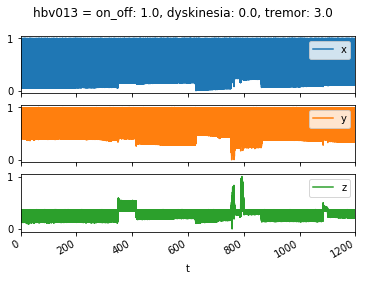

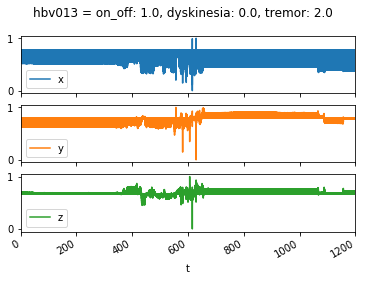

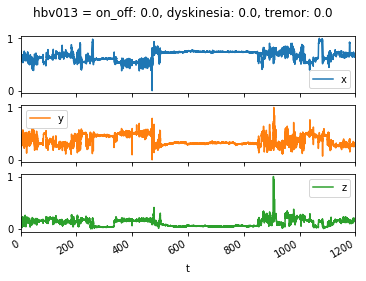

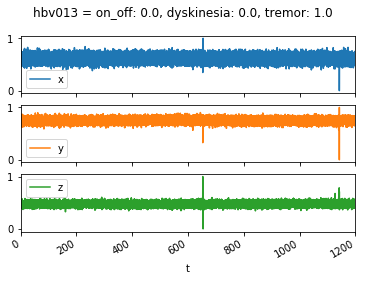

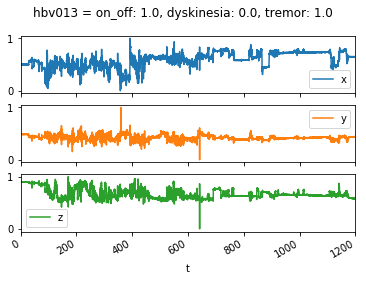

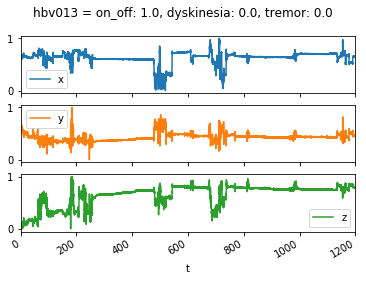

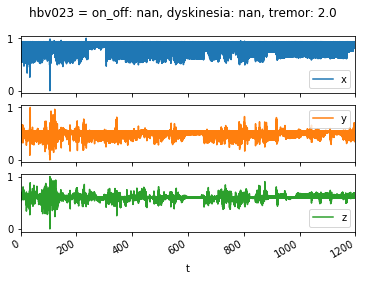

In [70]:
data_type='real' 
#data_real_subtype='smartphone_accelerometer' 
data_real_subtype='smartwatch_accelerometer'
#data_real_subtype='smartwatch_gyroscope'

path_train_data, df_train_label = define_data_type(data_type=data_type)

# List of interesting measurement id we want to look at 
list_measurement_id=['5b4c7c81-659d-40ea-a1fd-59622074fd10','ee053d95-c155-400d-ae42-fe24834ad4a9',
'ce51ee31-8553-4321-9f83-8cd3dabe2f66',
'e07708ff-7b8d-4070-af70-3aa81423ab5b',
#'7d3f4b7a-167f-4a26-9062-94ce9d8794c1',
'99af8d14-cd09-4107-9502-355378ba4e08',
#'7d5ac31a-cb53-40f7-8188-0b13724ea55c',
'9e43840b-dd89-498b-af1a-a62896a4d5d9',
'e391f546-bf8a-46c7-a16c-95bc02f40629']

# Filter df_train_label according to the measurement_id we are most interested in
df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)

# Display filtered df_train_label
#display(df_train_label)

###  Plot the accelerometer data 
# Path example: /home/sjoshi/codes/python/BeatPD/code/accelerometer_plots/real/smartwatch_gyroscope/
path = path_save_accelerometer_plots+'/'+data_type+'/'+data_real_subtype+'/'
plot_accelerometer(data_type=data_type, path_accelerometer_plots=path)


In [71]:
# Compute the occurences of each symptoms for each patient
df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(df_train_label=df_train_label)

Nb subject_id :  2


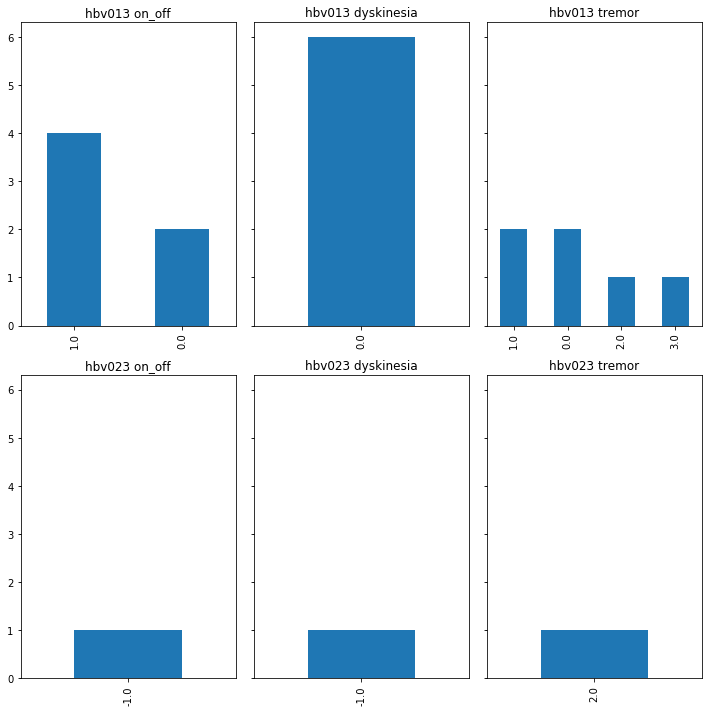

In [72]:
# Plot the graphs 
plot_symptoms_occurences(df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id)

# Comparing both databases


<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-0pky"></th>
    <th class="tg-0pky">CIS-PD</th>
    <th class="tg-0pky">REAL-PD</th>
  </tr>
  <tr>
    <td class="tg-0pky"># of subject_id training</td>
    <td class="tg-c3ow">16</td>
    <td class="tg-c3ow">12</td>
  </tr>
  <tr>
    <td class="tg-0pky"># of female training</td>
    <td class="tg-c3ow">5</td>
    <td class="tg-c3ow">7</td>
  </tr>
  <tr>
    <td class="tg-0pky"># of male training</td>
    <td class="tg-c3ow">11</td>
    <td class="tg-c3ow">5</td>
  </tr>
  <tr>
    <td class="tg-0pky">Age average (std deviation)</td>
    <td class="tg-c3ow">62.8125 (10.857)</td>
    <td class="tg-c3ow">59.833 (5.828)</td>
  </tr>
</table>



In [73]:
# DataFrame for specified subject_id
#display(df_train_label_subject_id.get_group('hbv013'))

#print(display(df_train_label_subject_id.get_group('hbv013')['tremor'].value_counts()))

# Graphs for a specific subject_id the 3 symptoms 
# df_train_label_subject_id.get_group('hbv014')['tremor'].value_counts().plot(kind='bar', title='tremor')
# df_train_label_subject_id.get_group('hbv014')['dyskinesia'].value_counts().plot(kind='bar', title='dys')
# df_train_label_subject_id.get_group('hbv014')['on_off'].value_counts().plot(kind='bar', title='on_off')


# Tests & Drafts, back-up space that's not important, just notes

In [74]:
20*60/59848

0.02005079534821548

In [75]:
# Change the default option to display all row with display(DF)
# pd.set_option('display.max_rows', 1000)

### How to filter a DataFrame

In [76]:
# Analysis of the data to find edge cases 


# Create variable with TRUE if nationality is USA
dys = df_train_label['dyskinesia'] > 1

# Create variable with TRUE if age is greater than 50
tre = df_train_label['on_off'] > 0

# Select all cases where nationality is USA and age is greater than 50
df_train_label[dys & tre]

,measurement_id,subject_id,on_off,dyskinesia,tremor


### Playing around with pct_change function to try and remove_silence

In [77]:
cars = {'Brand': ['Honda Civic','Toyota Corolla','Ford Focus','Audi A4','Toyota Corolla','Ford Focus','Audi A4'],
        'Price': [0,1,2,3,4,5,6]
        }

df = pd.DataFrame(cars, columns = ['Brand', 'Price'])
display(df)

display(df['Price'].pct_change(periods=1))

display(df['Price'].pct_change(periods=2))

display(df['Price'].pct_change(periods=5))

,Brand,Price
0,Honda Civic,0
1,Toyota Corolla,1
2,Ford Focus,2
3,Audi A4,3
4,Toyota Corolla,4
5,Ford Focus,5
6,Audi A4,6


0         NaN
1         inf
2    1.000000
3    0.500000
4    0.333333
5    0.250000
6    0.200000
Name: Price, dtype: float64

0         NaN
1         NaN
2         inf
3    2.000000
4    1.000000
5    0.666667
6    0.500000
Name: Price, dtype: float64

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    inf
6    5.0
Name: Price, dtype: float64